In [529]:
using SFGTools, PyPlot, Statistics

In [530]:
df = list_spectra(date=(2018,8,14), group=true, inexact="TL-DMPE-")
df[1:4]

,name,N,sizes,dates
,String,Int64,Array…,Array…
1,TL-DMPE-180703_EksplaPump,1,"[""[256, 4, 1]""]",[2018-08-14T00:00:00]
2,TL-DMPE-180703_SignalOnCam,1,"[""[256, 128, 1]""]",[2018-08-14T00:00:00]
3,TL-DMPE-180703_PumpProbe_LIGHT,201,"[""[256, 4, 1]""]",[2018-08-14T00:00:00]
4,TL-DMPE-180703_PumpProbe_BLACK,1,"[""[256, 4, 20]""]",[2018-08-14T00:00:00]
5,TL-DMPE-180703_PumpProbe_BIAS,1,"[""[256, 4, 200]""]",[2018-08-14T00:00:00]
6,TL-DMPE-180703_#2_PumpProbe_LIGHT,126,"[""[256, 4, 1]""]",[2018-08-14T00:00:00]


In [503]:
spectra_id  = 3
bias_id     = 5
dark_id     = 4
flat_id     = nothing
darkflat_id = nothing
pump_id     = 1

# Spectra
data_raw = load_spectra(df[:id][spectra_id])
@show spectra_events = rm_events!.(data_raw, width=2, minstd=4)
# Bias
bias = load_spectra(df[:id][bias_id])[1]
@show bias_events = rm_events!(bias)
# # Dark
# dark = load_spectra(df[:id][dark_id])[1]
# @show dark_events = rm_events!(dark)
# # Flat
# flat = load_spectra(df[:id][flat_id])[1]
# @show flat_events = rm_events!(flat)
# # Darkflat
# darkflat = load_spectra(df[:id][darkflat_id])[1]
# @show darkflat_events = rm_events!(darkflat)
# Pump
pump_spectrum = load_spectra(df[:id][1])[1]
@show pump_events = rm_events!(pump_spectrum, width=1);

bias_events = rm_events!(bias) = 0
pump_events = rm_events!(pump_spectrum, width=1) = 0


Let's take a look at the raw data:

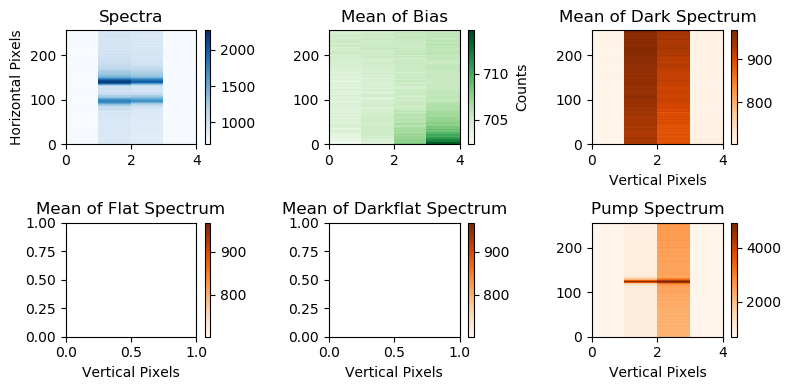

In [514]:
figure(figsize=(8,4))
subplot(2,3,1)
title("Spectra")
pcolor(data_raw[1][:,:,1], cmap=ColorMap("Blues"))
ylabel("Horizontal Pixels")
colorbar()
subplot(2,3,2)
title("Mean of Bias")
isdefined(Main, :bias) && pcolor(mean(bias, dims=3)[:,:,1], cmap=ColorMap("Greens"))
colorbar(label="Counts")
subplot(2,3,3)
title("Mean of Dark Spectrum")
isdefined(Main, :dark) && pcolor(mean(dark, dims=3)[:,:,1], cmap=ColorMap("Oranges"))
xlabel("Vertical Pixels")
colorbar()
subplot(2,3,4)
title("Mean of Flat Spectrum")
isdefined(Main, :flat) && pcolor(mean(flat, dims=3)[:,:,1], cmap=ColorMap("Oranges"))
xlabel("Vertical Pixels")
colorbar()
subplot(2,3,5)
title("Mean of Darkflat Spectrum")
isdefined(Main, :darkflat) && pcolor(mean(darkflat, dims=3)[:,:,1], cmap=ColorMap("Oranges"))
xlabel("Vertical Pixels")
colorbar()
subplot(2,3,6)
title("Pump Spectrum")
isdefined(Main, :pump_spectrum) && pcolor(mean(pump_spectrum, dims=3)[:,:,1], cmap=ColorMap("Oranges"))
xlabel("Vertical Pixels")
colorbar()

plt[:tight_layout]()

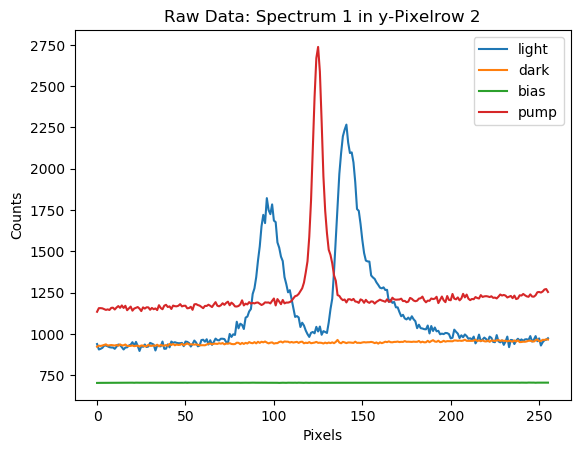

PyObject <matplotlib.legend.Legend object at 0x1a97e4160>

In [516]:
plot(data_raw[1][:,2,1], label="light")
plot(mean(dark[:,2,:], dims=2), label="dark")
plot(mean(bias[:,2,:], dims=2), label="bias")
plot(mean(mean(pump_spectrum[:,:,:], dims=3)[:,:,1], dims=2), label="pump")
title("Raw Data: Spectrum 1 in y-Pixelrow 2")
xlabel("Pixels")
ylabel("Counts")
legend()

## Fieldcorrection

Because `fieldcorrection!` overwrites `data` we copy it first in order to compare it to the corrected spectrum

In [335]:
data_corrected = deepcopy(data_raw)
fieldcorrection!.(data_corrected, bias=bias, dark=dark);

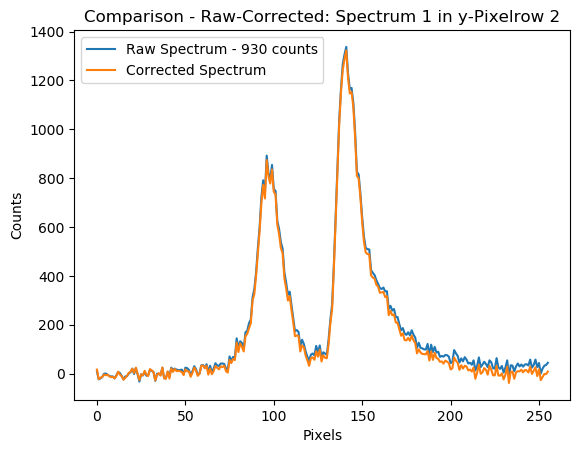

PyObject <matplotlib.legend.Legend object at 0x18e9e1668>

In [336]:
plot(data_raw[1][:,2,1] .- 930, label="Raw Spectrum - 930 counts")
plot(data_corrected[1][:,2,1], label="Corrected Spectrum")
title("Comparison - Raw-Corrected: Spectrum 1 in y-Pixelrow 2")
xlabel("Pixels")
ylabel("Counts")
legend()

## Averaging the Data

For better comparison with other spectra we are not interested in the total number of count but rather in the count rate.
The `average` function does divide the total counts by the exposure time:

In [337]:
data_avg = average.(data_corrected)
size(data_avg[1])

(256, 4)

It also removes all the singleton dimensions (in this case the thrid one)

## Get Wavelength and Wavenumber of the Data

To get the wavelength and wavenumber of the sum frequency light use `get_wavelength` and `get_wavenumber`. To get them for the corresponding IR use `get_ir_wavelength` and `get_ir_wavenumber`.

Because all spectra have the same wavenumbers we take them only from the first spectrum.

In [338]:
wavenumber = get_ir_wavenumber(data_avg[1])
@show minimum(wavenumber)
@show maximum(wavenumber);

minimum(wavenumber) = 2702.484755672009
maximum(wavenumber) = 3079.61634323515


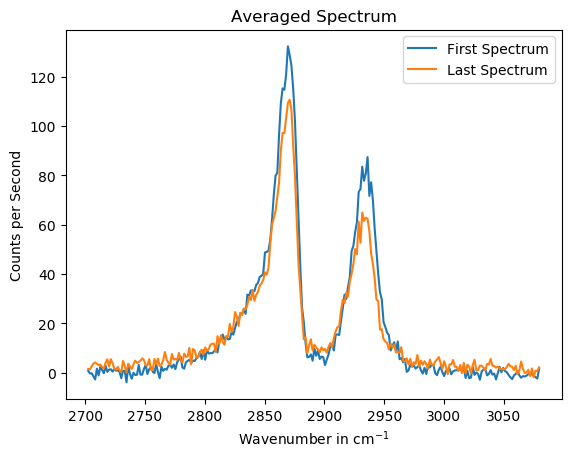

In [339]:
plot(wavenumber, data_avg[1][:,2], label="First Spectrum")
plot(wavenumber, data_avg[end][:,2], label="Last Spectrum")
title("Averaged Spectrum")
legend()
xlabel("Horizontal Pixels")
ylabel("Counts per Second")
xlabel(L"Wavenumber in cm$^{-1}$");

## Get the Delay Line Position

In [340]:
delaytime = get_pump_delay.(data_avg)
@show delaytime[1]
@show delaytime[end];

delaytime[1] = 760.1792303927806
delaytime[end] = 825.2909417754598


## Put the Signal and the Reference in Separate Matrices

The size of the dataset (number of different delay line positions) is

In [341]:
size(data_raw)

(201,)

and the sizes of the individual spectra are

In [342]:
size(data_raw[1])

(256, 4, 1)

In [372]:
sigidx = 3
refidx = 2

sigmat = Array{Float64}(undef, length(data_raw), size(data_raw[1], 1))
refmat = similar(sigmat)
for i = 1:size(sigmat, 1)
    sigmat[i,:] .= data_avg[i][:,sigidx,1]
    refmat[i,:] .= data_avg[i][:,refidx,1]
end

These Matrices look like this:

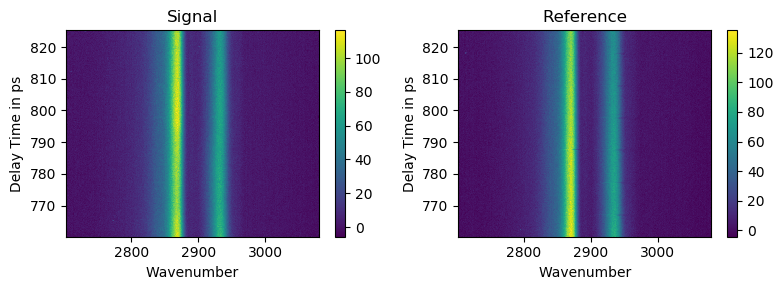

In [373]:
figure(figsize=(8,3))
subplot(1,2,1)
title("Signal")
xlabel("Wavenumber")
ylabel("Delay Time in ps")
pcolor(wavenumber, delaytime, sigmat)
colorbar()
subplot(1,2,2)
title("Reference")
xlabel("Wavenumber")
ylabel("Delay Time in ps")
pcolor(wavenumber, delaytime, refmat)
colorbar()
plt[:tight_layout]()

## Compare Signal and Reference

In [374]:
diffmat = sigmat .- refmat
ratiomat = sigmat ./ refmat;

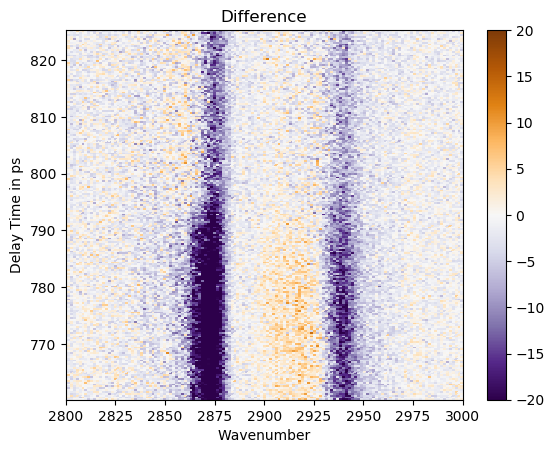

PyObject <matplotlib.colorbar.Colorbar object at 0x1a741be48>

In [377]:
countscale = 20
roi = ((2800, 3000), nothing)
title("Difference")
xlabel("Wavenumber")
ylabel("Delay Time in ps")
pcolor(wavenumber, delaytime, diffmat, cmap=ColorMap("PuOr_r"), vmin=-countscale, vmax=countscale)
xlim(roi[1])
ylim(roi[2])
colorbar()

## Correct the Shift Between Signal and Reference

In [378]:
r = 130:201
result = findpixelshift(sigmat[r,:], refmat[r,:], 2)

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,1.0]
 * Minimizer: [-0.5267859172908869,0.9404921721483755]
 * Minimum: 4.877462e+00
 * Iterations: 6
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: false 
     |x - x'| = 3.79e-08 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: false
     |f(x) - f(x')| = 3.82e-15 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 8.07e-10 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 17
 * Gradient Calls: 17

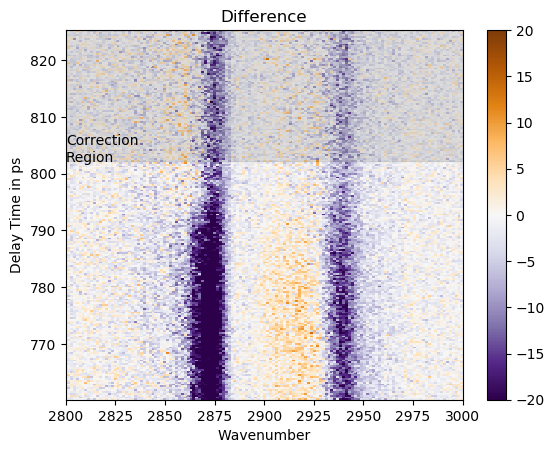

PyObject <matplotlib.colorbar.Colorbar object at 0x1a2756748>

In [379]:
axhspan(delaytime[r[1]], delaytime[r[end]], color="black", alpha=0.1)
title("Difference")
xlabel("Wavenumber")
ylabel("Delay Time in ps")
pcolor(wavenumber, delaytime, diffmat, cmap=ColorMap("PuOr_r"), vmin=-countscale, vmax=countscale)
xlim(roi[1])
ylim(roi[2])
text(xlim()[1], delaytime[r[1]], "Correction\nRegion")
colorbar()

In [380]:
refmat_shifted = pixelshift(refmat, 2, result.minimizer[1], result.minimizer[2]);

In [381]:
diffmat_shifted = sigmat .- refmat_shifted;

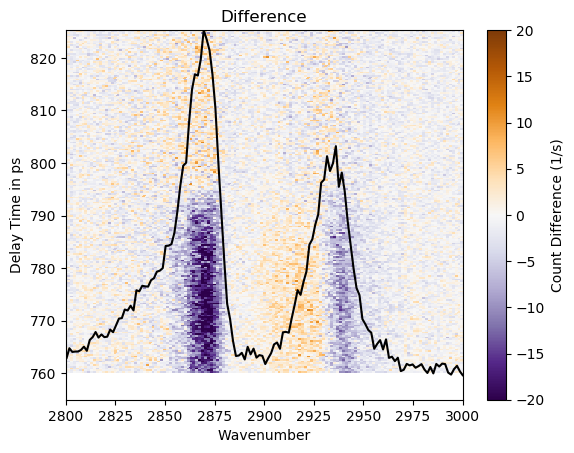

PyObject <matplotlib.colorbar.Colorbar object at 0x1c1258048>

In [528]:
title("Difference")
xlabel("Wavenumber")
ylabel("Delay Time in ps")
pcolor(wavenumber, delaytime, diffmat_shifted, cmap=ColorMap("PuOr_r"), vmin=-countscale, vmax=countscale)
adjusted_spectrum_for_plot = mean(data_avg[1][:,refidx,:], dims=3)[:,1,1] ./ 
    maximum(mean(data_avg[1][:,refidx,:], dims=3)[:,1,1]) .* 
    (maximum(delaytime) - minimum(delaytime)) .+ 
    minimum(delaytime)
plot(wavenumber, adjusted_spectrum_for_plot, color="black")
xlim(roi[1])
ylim(roi[2])
colorbar(label="Count Difference (1/s)")

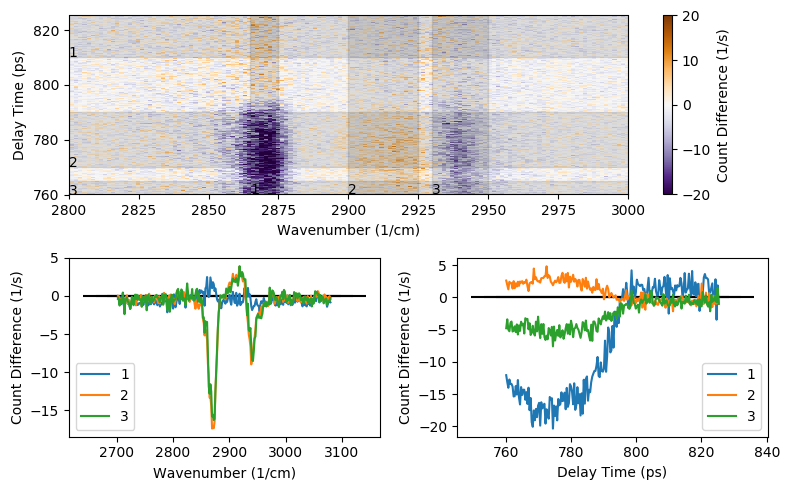

In [383]:
delayslices = ((810, 840), (770, 790), (760, 765))
wavenumberslices = ((2865, 2875), (2900, 2925), (2930, 2950))

figure(figsize=(8,5))
subplot(2,1,1)
pcolor(wavenumber, delaytime, diffmat_shifted, cmap=ColorMap("PuOr_r"), vmin=-countscale, vmax=countscale)
colorbar(label="Count Difference (1/s)")
xlim(roi[1])
ylim(roi[2])
for (i, (ds, ws)) in zip(delayslices, wavenumberslices) |> enumerate
    subplot(2,1,1)
    axvspan(ws..., color="black", alpha=0.1)
    axhspan(ds..., color="black", alpha=0.1)
    text(ws[1], ylim()[1], i)
    text(xlim()[1], ds[1], i)
    xlabel("Wavenumber (1/cm)")
    ylabel("Delay Time (ps)")
    
    subplot(2,2,3)
    idx = [0, 0]
    idx[1] = delaytime .- ds[1] .|> abs |> argmin
    idx[2] = delaytime .- ds[2] .|> abs |> argmin
    sort!(idx)
    meanslice_ds = mean(diffmat_shifted[idx[1]:idx[2], :], dims=1)[1,:]
    plot(wavenumber, meanslice_ds, label=i)
    hlines(0, xlim()...)
    legend()
    xlabel("Wavenumber (1/cm)")
    ylabel("Count Difference (1/s)")
    
    subplot(2,2,4)
    idx = [0, 0]
    idx[1] = wavenumber .- ws[1] .|> abs |> argmin
    idx[2] = wavenumber .- ws[2] .|> abs |> argmin
    sort!(idx)
    meanslice_ws = mean(diffmat_shifted[:, idx[1]:idx[2]], dims=2)[:,1]
    plot(delaytime, meanslice_ws, label=i)
    hlines(0, xlim()...)
    legend()
    xlabel("Delay Time (ps)")
    ylabel("Count Difference (1/s)")
end
plt[:tight_layout]()

## Save the Spectra as JSON

We save the the signal and the reference spectra in separate JSON files in order to open them in Matlab again for fitting.

First we build the arrays:

In [384]:
sigarray = [SFSpectrum(data_raw[i].id, sigmat[i,:]) for i = 1:length(data_raw)]
refarray = [SFSpectrum(data_raw[i].id, refmat_shifted[i,:]) for i = 1:length(data_raw)];

In [385]:
spectrumname = get_attribute(data_raw[1], "name")
savejson("./Data/export/json_test/$(spectrumname)_signals.json", sigarray)
savejson("./Data/export/json_test/$(spectrumname)_references.json", refarray)

2864233

You will then have to batch fit everything via Matlab evaluating the fit parameter, go back, adjust the parameters, etc...

## Load Fit Table

In [387]:
using DataFrames, CSV, Statistics

In [451]:
fitdata_ref = CSV.read("./Data/export/json_test/TL-DMPE-180703_PumpProbe_LIGHT_references.csv", allowmissing=:none)
head(fitdata_ref)

,id,A01,A02,A03,A04,A05,A06,G01,G02,G03,G04,G05,G06,NR,Offset,w01,w02,w03,w04,w05,w06
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Float64,Float64,Int64
1,63669948365228,236.464,13.4637,-91.7175,-11.2042,-146.425,18.9285,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
2,63669948375449,235.543,13.1031,-92.0398,-11.0375,-146.548,19.7868,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
3,63669948385718,236.294,17.0287,-90.638,-10.6067,-146.064,19.3621,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
4,63669948395928,236.301,14.8468,-91.1569,-11.1978,-146.708,20.0585,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
5,63669948406177,235.029,13.9307,-92.0041,-10.0154,-147.388,21.134,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
6,63669948416387,237.351,12.9721,-90.3411,-12.268,-144.323,18.1975,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945


In [452]:
fitdata_sig = CSV.read("./Data/export/json_test/TL-DMPE-180703_PumpProbe_LIGHT_signals.csv", allowmissing=:none)
head(fitdata_sig)

,id,A01,A02,A03,A04,A05,A06,G01,G02,G03,G04,G05,G06,NR,Offset,w01,w02,w03,w04,w05,w06
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Int64,Float64,Float64,Int64
1,63669948365228,237.726,14.966,-84.9982,-9.63669,-151.935,27.5622,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
2,63669948375449,236.037,9.4704,-86.6613,-9.00142,-151.607,27.5149,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
3,63669948385718,236.155,12.8113,-84.6976,-9.93379,-150.789,27.2898,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
4,63669948395928,237.046,11.9008,-85.6919,-9.60201,-150.154,27.3602,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
5,63669948406177,233.66,12.8985,-84.6547,-9.2078,-149.442,25.7069,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945
6,63669948416387,234.487,13.0916,-83.8042,-10.1935,-148.331,25.3301,45,8,8.5,7.25,14.4,8.2,0,0.8,2843.5,2861.2,2875,2893.5,2933.6,2945


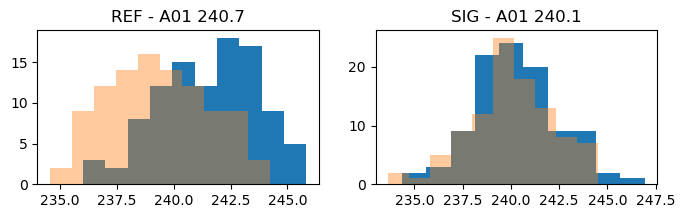

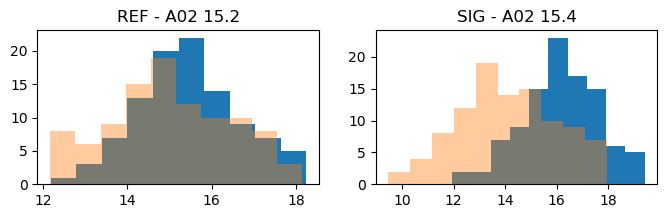

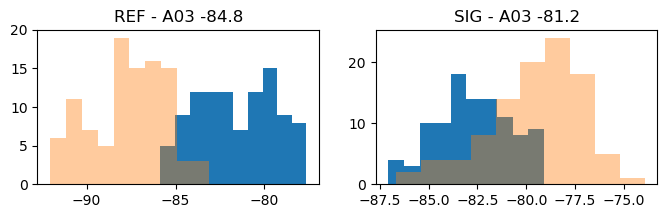

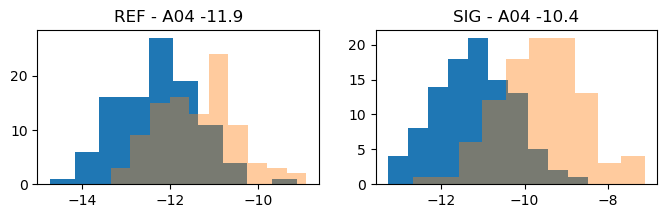

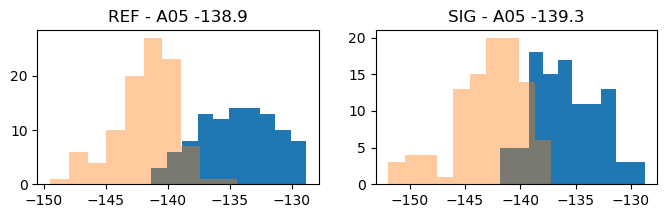

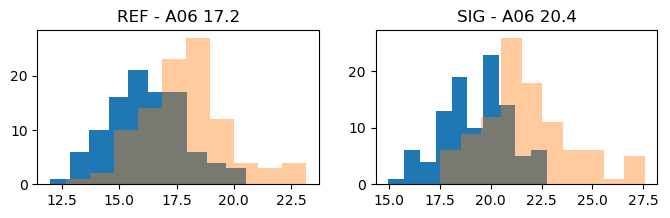

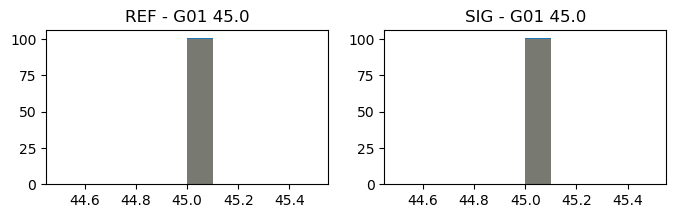

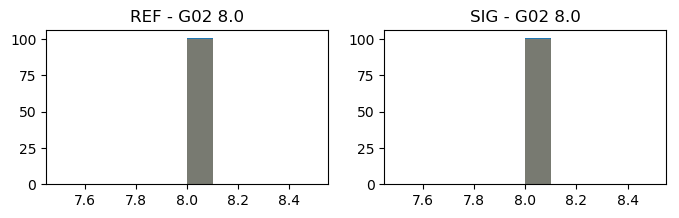

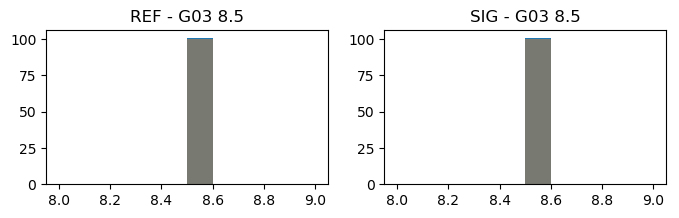

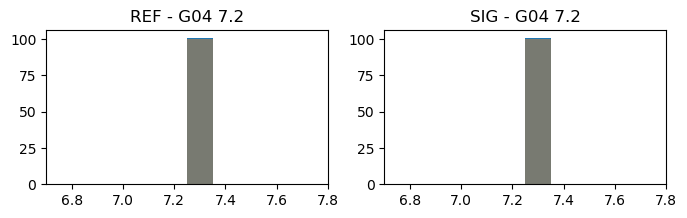

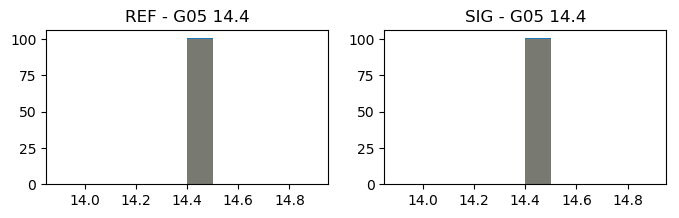

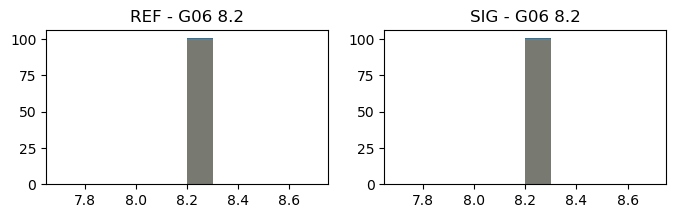

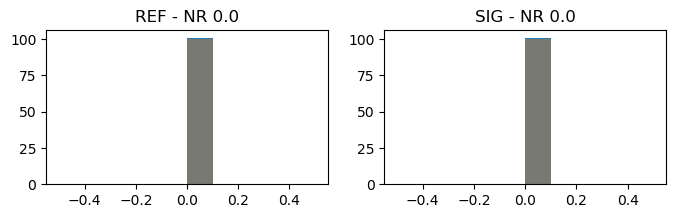

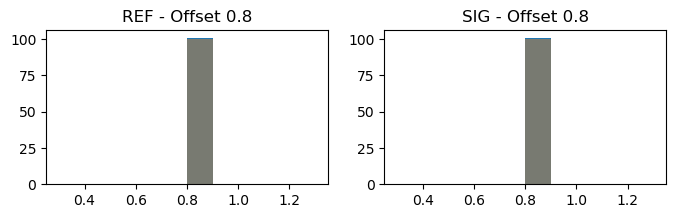

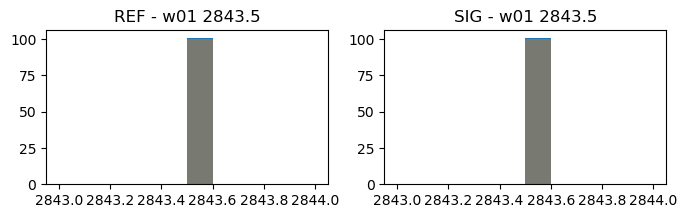

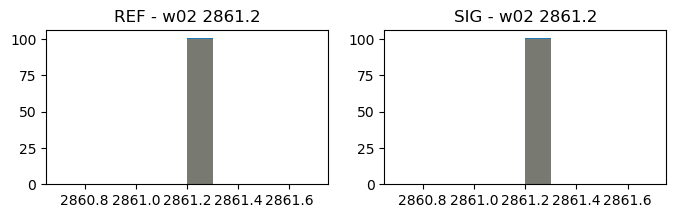

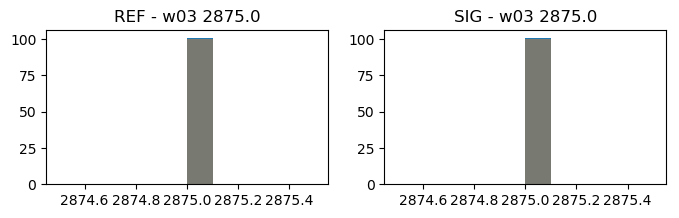

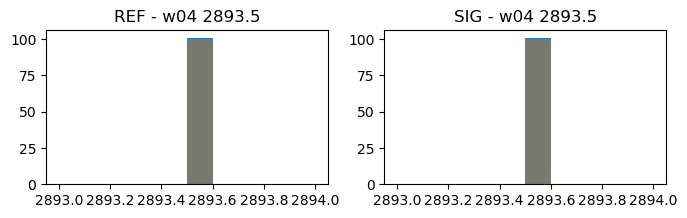

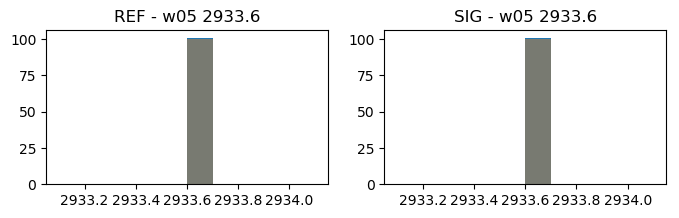

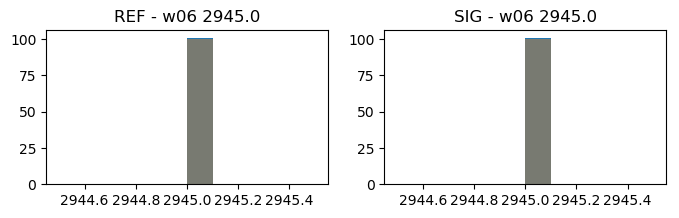

In [453]:
for name in names(fitdata_ref)[2:end]
    figure(figsize=(8,2))
    subplot(1,2,1)
    plt[:hist](fitdata_ref[name][101:201])
    plt[:hist](fitdata_ref[name][1:100], alpha=0.4)
    title("REF - " * string(name) * " " * string(round(median(fitdata_ref[name]), digits=1)))
    
    subplot(1,2,2)
    plt[:hist](fitdata_sig[name][101:201])
    plt[:hist](fitdata_sig[name][1:100], alpha=0.4)
    title("SIG - " * string(name) * " " * string(round(median(fitdata_sig[name]), digits=1)))
    
end

In [479]:
sym = eval(Meta.parse(":A01"))
fitdata_ref[sym]

201-element Array{Float64,1}:
 236.463503472525
 235.543249124786
 236.294239764133
 236.300725617993
 235.028994992925
 237.350711719351
 238.270244941013
 241.474733163335
 238.852970039827
 239.869350656389
 237.164238893444
 239.764567197314
 236.290814762994
   ⋮             
 238.650143440763
 240.83746190772 
 240.692173174313
 239.005697928783
 239.291034982139
 239.874676915862
 242.05060786957 
 241.767334899536
 240.565430160885
 239.605194933911
 242.313685945372
 237.755569634421

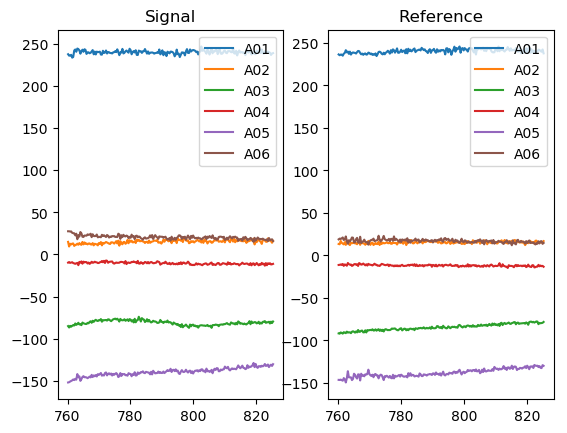

PyObject <matplotlib.legend.Legend object at 0x1b1edbdd8>

In [454]:
figure()
subplot(121)
n = names(fitdata_ref)
for i in 2:7
    plot(delaytime, fitdata_sig[n[i]], label=n[i])
end
title("Signal")
legend()

subplot(122)
for i in 2:7
    plot(delaytime, fitdata_ref[n[i]], label=n[i])
end
title("Reference")
legend()

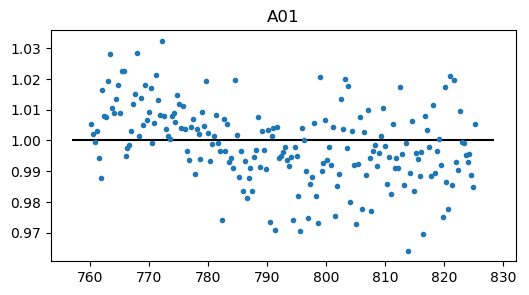

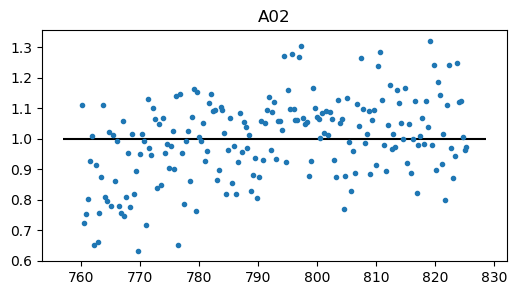

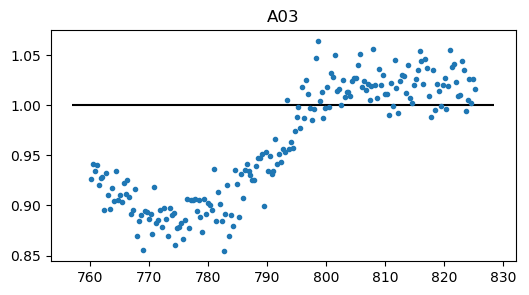

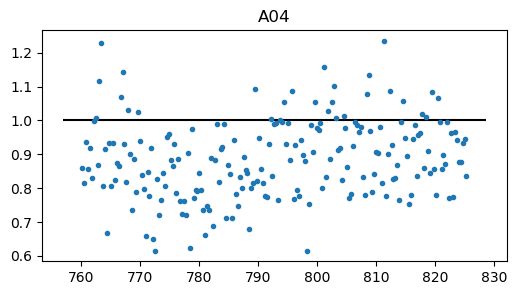

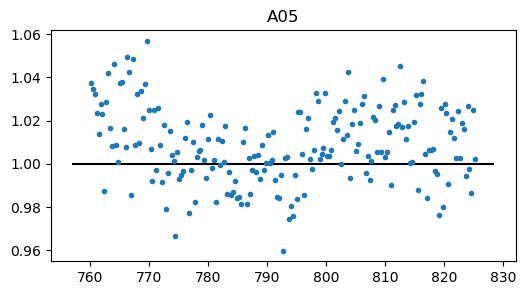

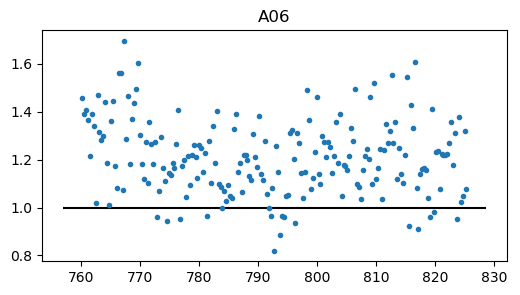

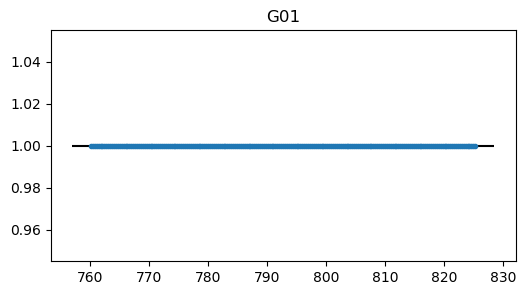

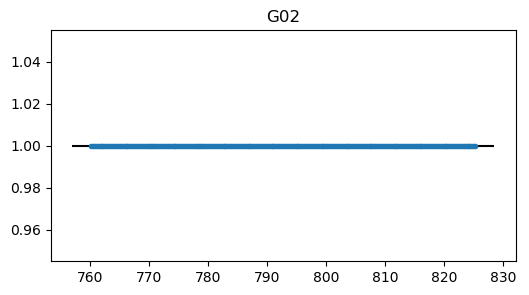

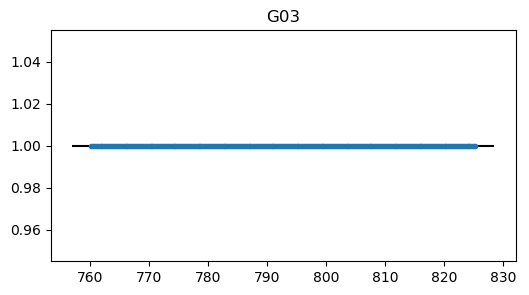

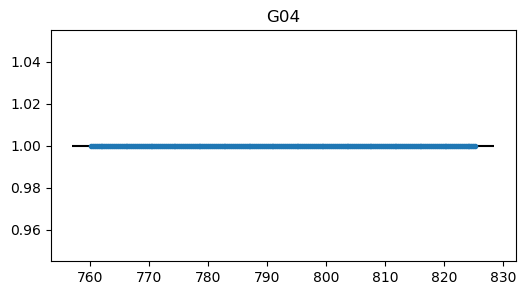

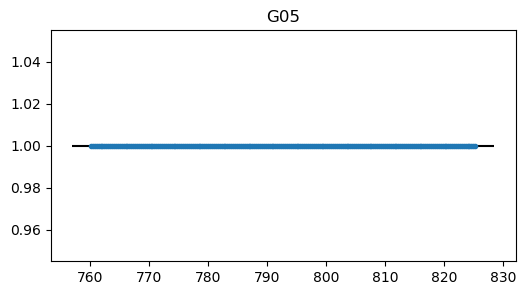

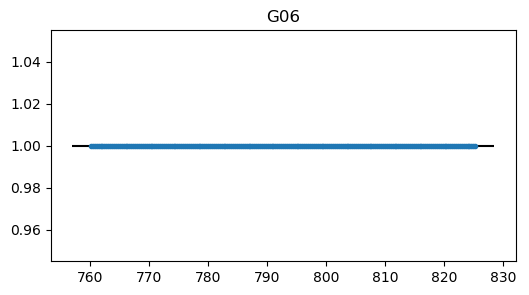

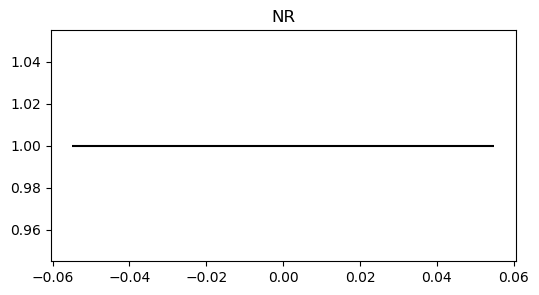

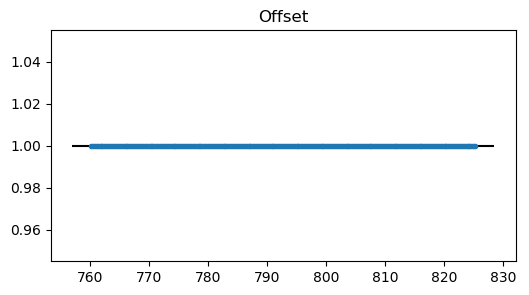

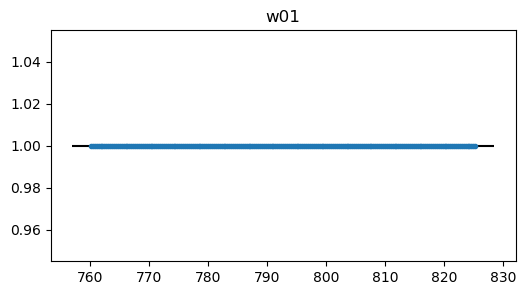

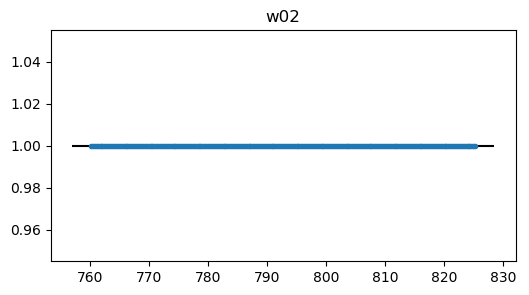

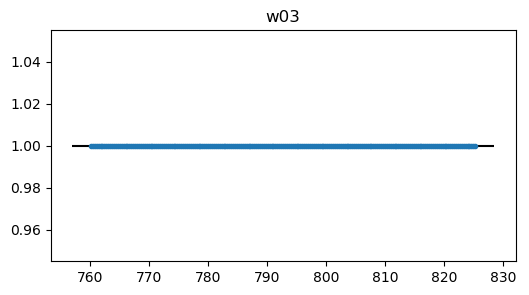

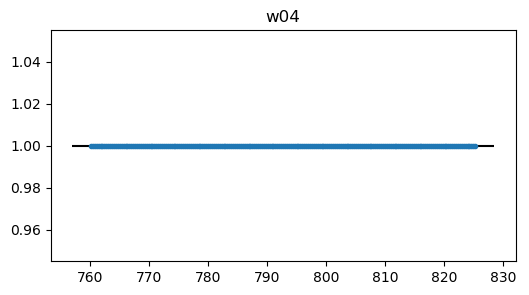

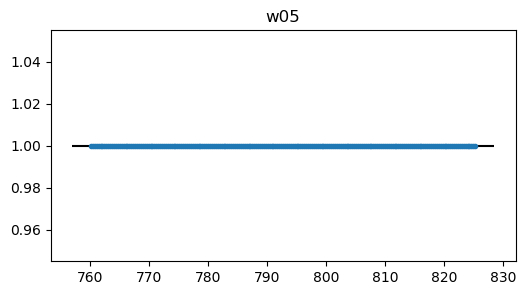

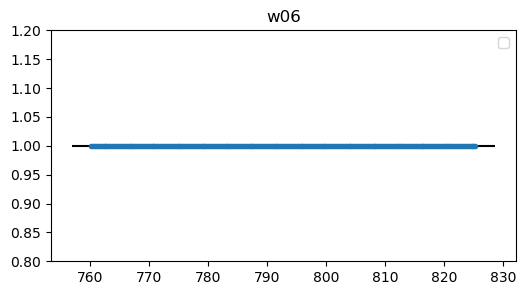

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x1a2690ac8>

In [489]:

for i in 2:length(fitdata_ref)
    
    figure(figsize=(6,3))
    title(n[i])
    s = fitdata_sig[n[i]]
    r = fitdata_ref[n[i]]
    
    rat = s ./ r
    
    plot(delaytime, rat, ".")
    hlines(1, xlim()...)
end
ylim(0.8, 1.2)
legend()